In [23]:
from hyp_solver3 import HypProblem, Mesh, Solver
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [24]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]
# C = [2.3,0.9]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))


G11 = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G12 = lambda t: - G11(t)
G21 = lambda t: (np.sin(t)) / (np.cos(t) - 4* np.sin(t))
G22 = lambda t: - G21(t)

F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0

phi_dx = lambda s, x, y : 2*x - 2*x_an(s, T[1]) 
phi_dy = lambda s, x, y : 2*y - 2*y_an(s, T[1]) 

hyp_problem = HypProblem(T=T, S=S, C=C, B=[[B11, B12], [B21, B22]], 
                         F=[F1, F2], G=[[G11, G12], [G21, G22]], 
                         X0=x0, Y0=y0, phi_dx=phi_dx, phi_dy=phi_dy)

mesh = Mesh(hyp_problem, 70)
solver = Solver()

In [25]:
def plot_final(mesh):
    nodes = mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    plt.subplot(2, 1, 1)
    plt.plot(s, x, "ro")
    plt.plot(s, [x_an(si, T[1]) for si in s], "b-")
    plt.ylabel("x")
    plt.subplot(2, 1, 2)
    plt.plot(s, y, "ro")
    plt.plot(s, [y_an(si, T[1]) for si in s], "b-")
    plt.ylabel("y")

    deltas_x = [abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)]
    deltas_y = [abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)]
        
    print(f"dx:{np.max(deltas_x)}\ndy:{np.max(deltas_y)}")


def plot_left(mesh):
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    print(y)
    plt.subplot(2, 1, 1)
    plt.plot(t, x, "ro")
    plt.plot(t, [x_an(S[0], ti) for ti in t], "b-")
    plt.ylabel("x")
    plt.subplot(2, 1, 2)
    plt.plot(t, y, "ro")
    plt.plot(t, [y_an(S[0], ti) for ti in t], "b-")
    plt.ylabel("y")

    deltas_x = [abs(xi-x_an(S[0],ti)) for ti, xi in zip(t, x)]
    deltas_y = [abs(yi-y_an(S[0],ti)) for ti, yi in zip(t, y)]
        
    print(f"dx:{np.max(deltas_x)}\ndy:{np.max(deltas_y)}")


def plot_v(mesh, hyp_problem):
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    v_true = [G22_true(ti) for ti in t]
    v = [hyp_problem.G22(ti) for ti in t]
    
    plt.plot(t, v, "ro")
    plt.plot(t, v_true, "b-")
    plt.legend(["v", "v_an"])
    plt.ylabel("v")

In [28]:
# Первое приближение ===============================================
# uk_0 = np.random.random(len(t_h))
G22_0 = lambda t: G22_true(t)+1
# G22_0 = lambda t: G22_true(t)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)



dx:0.00014232570046113224
dy:0.0670163709640269


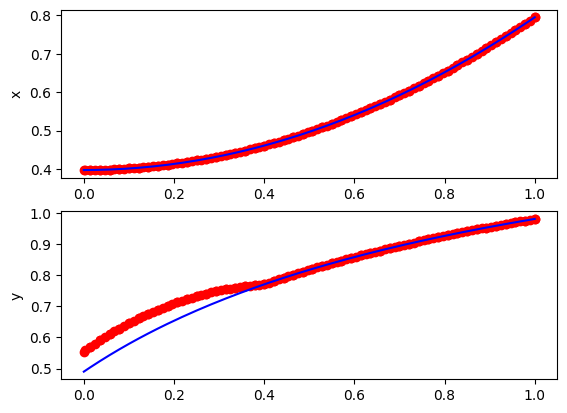

In [29]:
plot_final(mesh)

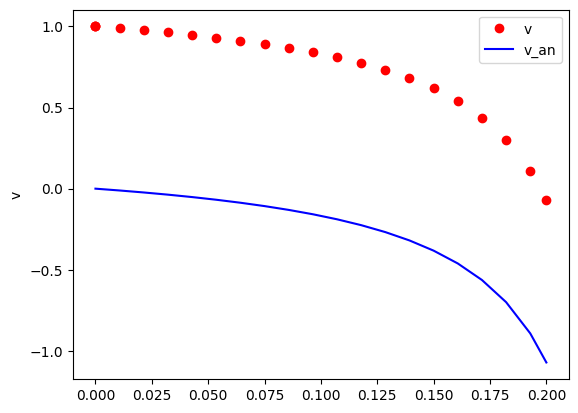

In [30]:
plot_v(mesh, hyp_problem)

In [31]:
nodes = mesh.get_border(type_border="left", sort_t=True)
t_mesh = np.unique([node[0][3] for node in nodes])

def model(v):
    G22_0 = lambda t: np.interp(t, t_mesh, v)
    G21_0 = lambda t:  - G22_0(t)
    hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])
    
    solver.solve_initial(mesh, hyp_problem)
    solver.solver_center(mesh, hyp_problem)
    solver.solver_final(mesh, hyp_problem)

    nodes = mesh.get_border(type_border="final", sort_s=True)
    s_final = [node[0][2] for node in nodes]
    x_final = [node[1][0][0] for node in nodes]
    y_final = [node[1][0][1] for node in nodes]

    f = [(xi-x_an(si, T[1]))**2+(yi-y_an(si, T[1]))**2 for xi, yi, si in zip(x_final, y_final, s_final)]
    return scipy.integrate.trapezoid(f, s_final)

In [32]:
v0 = [G22_true(ti)+1 for ti in t_mesh]

In [33]:
rez = scipy.optimize.minimize(model, v0)

In [34]:
G22_0 = lambda t: np.interp(t, t_mesh, rez.x)
G21_0 = lambda t:  - G22_0(t)
hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])

solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)

dx:1.5614343600256486e-05
dy:0.011474351369872071


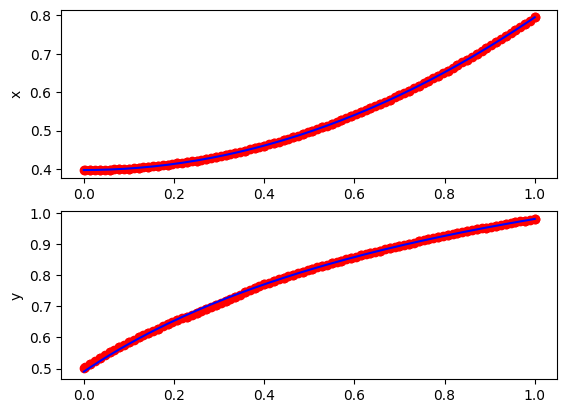

In [35]:
plot_final(mesh)

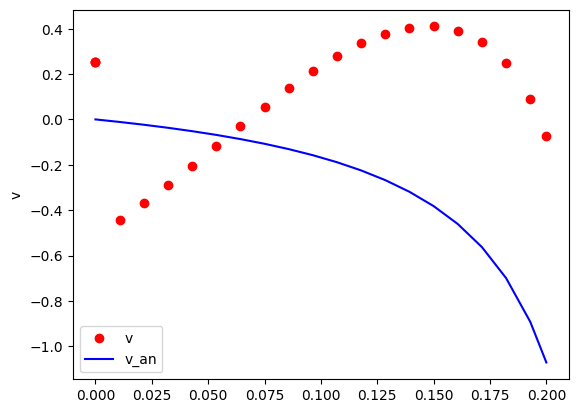

In [36]:
plot_v(mesh, hyp_problem)

[0.5, 0.5, 0.5, 0.4995476180357431, 0.49751501205383347, 0.4959413962654397, 0.4948188973807786, 0.4941241532703123, 0.4938219226770779, 0.49386800614883813, 0.49421118088712634, 0.49479580364982095, 0.49556363597294284, 0.4964554721744508, 0.49741232638804767, 0.4983768370403548, 0.4992937983466024, 0.5001112932336749, 0.5007808216382524, 0.5012572206968496, 0.5014978766187949, 0.5015076402904929]
dx:8.9502028125521e-06
dy:0.011474351369872071


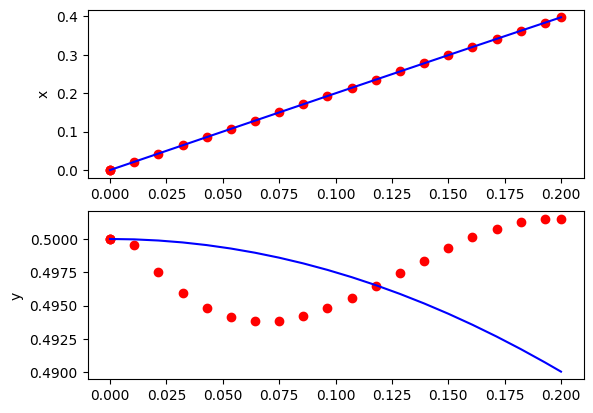

In [37]:
plot_left(mesh)